# Final Presentation part2

### mxnet

* 解构 bag of tricks 网络结构角度 big little network; 计算参数量的减少；
* gluoncv（mxnet）

### pytorch
* 动态表达 feature map （GAN）
* 设计网络结构的实现以及 可视化逐层表达
* ofa可以达到的supernet training 的优秀结果
* darts 的双层优化，如何优化层权重alpha 以及 参数weight
* supernet train 每条path的训练曲线能否同时work， 如果不行，那么怎么进行调整
* tuner的实验对比，bayes optim为什么work， 探索与利用



In [7]:
import os, time, shutil, zipfile
import matplotlib.pyplot as plt
import numpy as np

import mxnet as mx
from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import gluoncv
from gluoncv.utils import makedirs, download
from gluoncv.model_zoo import get_model
from gluoncv.utils import LRScheduler

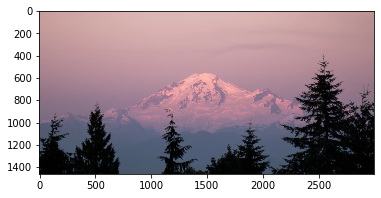

In [8]:
download('https://raw.githubusercontent.com/dmlc/web-data/master/gluoncv/classification/mt_baker.jpg', path='./')
filename = 'mt_baker.jpg'
img = mx.image.imread(filename)
plt.imshow(img.asnumpy())

In [9]:
model_name = 'ResNet50_v1'
net = gluoncv.model_zoo.get_model(model_name, pretrained=True)

In [14]:
gluoncv.utils.viz.plot_network(net, (1, 3, 224, 224), 'sample/resnet50_v1')

In [18]:
# net = get_model("resnet50_v1", pretrained=True)
net.initialize()
net.hybridize()
x = mx.nd.random.normal(shape=(1, 3, 416, 416))
out = net(x)
net.export("resnet50_v1")

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv10_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv10_batchnorm0_gamma' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv10_batchnorm0_beta' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/parameter.py:887: UserWarning: Parameter 'resnetv10_batchnorm0_running_mean' is alre

In [10]:
# json wrong
from gluoncv.utils import export_block
export_block('resnet50_v1', net, preprocess=True, layout='HWC')
print('resnet50_v1-symbol.json Done.')

Done.


In [20]:
from gluoncv.model_zoo import get_model
import mxnet as mx

net = get_model("yolo3_darknet53_voc", pretrained=True)
net.hybridize()
x = mx.nd.random.normal(shape=(1, 3, 416, 416))
out = net(x)
net.export("yolo3_darknet53_voc")

223070KB [00:04, 53943.27KB/s]                            


In [22]:
!python calculate_flops.py -s yolo3_darknet53_voc-symbol.json -ds data,1,3,224,224 

[10:03:17] src/executor/graph_executor.cc:1984: Subgraph backend MKLDNN is activated.
Traceback (most recent call last):
  File "calculate_flops.py", line 109, in <module>
    total_flops += out_shape_produt * product(arg_params[layer_name + '_weight'].shape) * data_shapes[0][1][0]
KeyError: 'darknetv30_conv0_fwd_weight'


In [16]:
!python calculate_flops.py -s resnet50_v1-symbol.json -ds data,1,3,224,224 -ls softmax_label,1,1000 

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:67: UserWarning: Data provided by label_shapes don't match names specified by label_names ([DataDesc[softmax_label,(1, 1000),<class 'numpy.float32'>,NCHW]] vs. [])
  warnings.warn(msg)
[09:59:39] src/executor/graph_executor.cc:1984: Subgraph backend MKLDNN is activated.
Traceback (most recent call last):
  File "calculate_flops.py", line 68, in <module>
    model.bind(data_shapes=data_shapes, label_shapes=label_shapes, for_training=False)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/module.py", line 429, in bind
    state_names=self._state_names)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/executor_group.py", line 280, in __init__
    self.bind_exec(data_shapes, label_shapes, shared_group)
  File "/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/executor_group.py", line 383, in bi

In [2]:
!python calculate_flops.py -s resnet50_v1-symbol.json -ds data,1,3,224,224

[10:09:32] src/executor/graph_executor.cc:1984: Subgraph backend MKLDNN is activated.
flops:  3868.961792  MFLOPS
model size:  97.56436157226562  MB


<kbd>6. BigLittle Network</kbd> <br />

In [3]:
from blresnet import get_blmodel
# blnet = get_blmodel('blresnet50_v1')

In [4]:
def get_blnet():
    blnet = get_blmodel('blresnet50_v1')
    blnet.initialize()
    return blnet
t = get_blnet()

In [10]:
import mxnet as mx
blnet = get_blmodel('blresnet50_v1')
blnet.initialize()
blnet.hybridize()
x = mx.nd.random.normal(shape=(1, 3, 224, 224))
out = blnet(x)
blnet.export("blresnet50_v1")

In [9]:
t.summary

<bound method Block.summary of BLResNetV1(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
    (2): Activation(relu)
    (3): BLModule_0(
      (relu): Activation(relu)
      (big_branch): HybridSequential(
        (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      )
      (little_branch): HybridSequential(
        (0): Conv2D(64 -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
        (2): Activation(relu)
        (3): Conv2D(32 -> 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm(axis=

In [10]:
x = mx.nd.ones((1, 3, 224, 224))

In [11]:
t.summary(x)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 224, 224)               0
            Conv2D-1                           (1, 64, 112, 112)            9408
         BatchNorm-2                           (1, 64, 112, 112)             256
        Activation-3                           (1, 64, 112, 112)               0
            Conv2D-4                             (1, 64, 56, 56)           36864
         BatchNorm-5                             (1, 64, 56, 56)             256
            Conv2D-6                           (1, 32, 112, 112)           18432
         BatchNorm-7                           (1, 32, 112, 112)             128
        Activation-8                           (1, 32, 112, 112)               0
            Conv2D-9                             (1, 32, 56, 56)            9216
        BatchNorm-10        

In [13]:
gluoncv.utils.viz.plot_network(t, (1, 3, 224, 224), 'sample/blresnet')

![jupyter](sample/blresnet.png)

![jupyter](sample/blblock.JPG)

![jupyter](sample/residual.png)

In [5]:
transformed_img = gluoncv.data.transforms.presets.imagenet.transform_eval(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


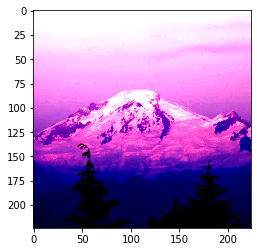

In [6]:
import numpy as np
plt.imshow(np.transpose(transformed_img[0].asnumpy(), (1, 2, 0)))

In [7]:
pred = net(transformed_img)